# This is it

The idea behind this notebook, if successful, will lead to inevitable world domination.

The state of that.

## Download missing files

In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2018-12-07 10:06:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2018-12-07 10:06:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  17.0MB/s    in 47s     

2018-12-07 10:06:58 (17.5 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


## Import stuff

In [0]:
import pandas as pd
import numpy as np
from keras.layers.embeddings import Embedding
from keras.layers import Dropout, BatchNormalization, Input, Embedding, Flatten, concatenate, Dense, LSTM, subtract, multiply, Bidirectional, Lambda
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import keras.backend as keras_backend

## Setup Hyperparameters

In [0]:
GLOVE_FILE = 'glove.6B.300d.txt'
SEQ_LENGTH = 25
EMBEDDING_SIZE = 300
LSTM_UNITS = 256
FEAT_DENSE_OUTPUT = 100
FEAT_ACTIVATION = 'relu'
MERGED_DENSE_ACTIVATION = 'relu'
MERGED_DENSE_OUTPUT = 200
DROPOUT_RATE = 0.1
LOSS = 'binary_crossentropy'
OPTIMIZER = 'adam'
CHECKPOINT_FILE = 'final-{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}.h5'
SUBMISSION_FILE = 'final-test.h5'
EPOCHS = 25
BATCH_SIZE = 1024

## Setup Train Data

In [0]:
# Read and prepare the questions text training set
df_train = pd.read_csv('train_data.csv')
df_labels = pd.read_csv('train_labels.csv')

df_train = df_train.astype({'question1': str, 'question2': str})

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323144 entries, 0 to 323143
Data columns (total 3 columns):
id           323144 non-null int64
question1    323144 non-null object
question2    323144 non-null object
dtypes: int64(1), object(2)
memory usage: 7.4+ MB


In [0]:
# Read and prepare the extracted features train set
# Load Features
features = pd.read_csv('feats.csv')
fuzzy = pd.read_csv('fuzz_feats.csv')

In [8]:
fuzzy.index

RangeIndex(start=0, stop=323144, step=1)

In [0]:
features_merged = pd.concat([features, fuzzy], axis=1, join_axes=[features.index])

In [26]:
features = features_merged
features.head()

,same_words_fraction,jacard_similarity,q1_len,q2_len,fuzz_qratio,fuzz_WRatio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,0.480000,0.916667,66,57,93,95,100,100,89,100,93
1,0.321429,0.368421,53,90,67,86,74,100,75,86,63
2,0.192308,0.142857,73,59,54,63,53,100,71,66,66
3,0.043478,0.000000,49,62,35,35,35,37,38,36,36
4,0.227273,0.250000,74,39,45,86,56,100,63,67,47


In [0]:
# Create the questions vocabulary
tokenizer = Tokenizer()
questions = pd.concat([df_train['question1'], df_train['question2']])
tokenizer.fit_on_texts(questions)

# We add one, because we will need to specify the integer for the largest encoded word as an array index, 
# e.g. words encoded 1 to 21 with array indices 0 to 21 or 22 positions.
vocab_size = len(tokenizer.word_index) + 1

In [0]:
# Integer Encode & pad the questions
q1_int_sequence = tokenizer.texts_to_sequences(df_train['question1'])
q2_int_sequence = tokenizer.texts_to_sequences(df_train['question2'])

q1_padded = pad_sequences(q1_int_sequence, maxlen=SEQ_LENGTH)
q2_padded = pad_sequences(q2_int_sequence, maxlen=SEQ_LENGTH)

In [0]:
# Load the Glove Embeddings
f = open(GLOVE_FILE)

embeddings_index = dict()
for line in f:
    embedding = line.split()
    word_key = embedding[0]
    word_weights = np.asarray(embedding[1:], dtype='float32')
    embeddings_index[word_key] = word_weights
f.close()

# Create the embedding matrix of the embeddings contained in the dataset
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding = embeddings_index.get(word)
    if embedding is not None:
        embedding_matrix[i] = embedding

## Create the Neural Network

In [0]:
# Initial, siamese layers
embedding_layer = Embedding(vocab_size, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=SEQ_LENGTH, trainable=False)
lstm_layer = Bidirectional(LSTM(LSTM_UNITS, activation='tanh'))

q1_input = Input(shape=(SEQ_LENGTH,))
q1_model = embedding_layer(q1_input)
q1_model = lstm_layer(q1_model)

q2_input = Input(shape=(SEQ_LENGTH,))
q2_model = embedding_layer(q2_input)
q2_model = lstm_layer(q2_model)

# Create Features Layer
features_layer = Input(shape=(features.shape[1],), dtype='float32')
features_dense = Dense(FEAT_DENSE_OUTPUT, activation=FEAT_ACTIVATION)(features_layer)

In [0]:
# Concatenate the outputs of the previous layers and create the merged layers.
merged_subtract = subtract([q1_model, q2_model])
merged_multiply = multiply([q1_model, q2_model])
merged_model = concatenate([q1_model, q2_model, merged_subtract, merged_multiply, features_dense])

merged_model = Dropout(DROPOUT_RATE)(merged_model)
merged_model = BatchNormalization()(merged_model)
merged_model = Dense(MERGED_DENSE_OUTPUT, activation=MERGED_DENSE_ACTIVATION)(merged_model)
merged_model = Dropout(DROPOUT_RATE)(merged_model)
merged_model = BatchNormalization()(merged_model)
merged_model = Dense(MERGED_DENSE_OUTPUT, activation=MERGED_DENSE_ACTIVATION)(merged_model)
merged_model = Dropout(DROPOUT_RATE)(merged_model)
merged_model = BatchNormalization()(merged_model)
merged_model = Dense(1, activation='sigmoid')(merged_model)

In [0]:
# Compile the model
model = Model(inputs=[q1_input,q2_input, features_layer], outputs=merged_model)

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 25, 300)      23224200    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 512)          1140736     embedding_1[0][0]                
          

## Train the Neural Network

### Train-validation split

In [0]:
# Word Sequences split
# Note: use same random stae for splitting both sets.
rng_state = 42

X = np.stack((q1_padded, q2_padded), axis=1)
y = df_labels['is_duplicate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rng_state)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

# Features split
feat_train, feat_test, y_train, y_test = train_test_split(features, y, test_size=0.1, random_state=rng_state)

### Train

In [31]:
callbacks = [EarlyStopping(patience=5, restore_best_weights=True), 
             ModelCheckpoint(CHECKPOINT_FILE, monitor='val_acc', save_best_only=True)]

# history = model.fit([Q1_train, Q2_train, feat_train], y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
#                     callbacks=callbacks, validation_data=([Q1_test, Q2_test, feat_test], y_test))

history = model.fit([Q1_train, Q2_train, feat_train], y_train, epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, callbacks=callbacks, validation_split=0.1)

Train on 261746 samples, validate on 29083 samples
Epoch 1/25
261746/261746 [==============================] - 122s 467us/step - loss: 0.4692 - acc: 0.7614 - val_loss: 0.4197 - val_acc: 0.7935
Epoch 2/25
261746/261746 [==============================] - 118s 452us/step - loss: 0.3931 - acc: 0.8091 - val_loss: 0.3917 - val_acc: 0.8110
Epoch 3/25
261746/261746 [==============================] - 118s 453us/step - loss: 0.3538 - acc: 0.8338 - val_loss: 0.3616 - val_acc: 0.8296
Epoch 4/25
261746/261746 [==============================] - 118s 453us/step - loss: 0.3204 - acc: 0.8528 - val_loss: 0.3572 - val_acc: 0.8348
Epoch 5/25
261746/261746 [==============================] - 118s 452us/step - loss: 0.2865 - acc: 0.8717 - val_loss: 0.3586 - val_acc: 0.8364
Epoch 6/25
261746/261746 [==============================] - 118s 453us/step - loss: 0.2551 - acc: 0.8874 - val_loss: 0.3640 - val_acc: 0.8412
Epoch 7/25
261746/261746 [==============================] - 118s 452us/step - loss: 0.2246 - acc:

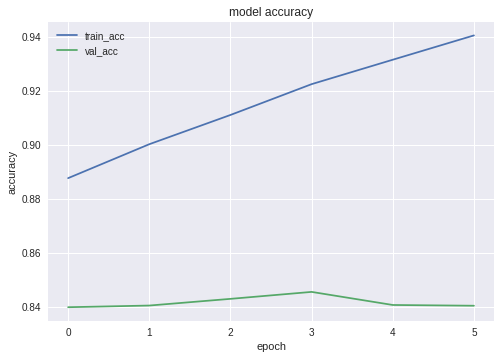

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.show()

### Load the best checkpoint and test it
The checkpoint saves the best model depending on validation, but the variable still contains the last iteration.

We load the best model and then test it on the test data.

In [0]:
model = load_model('final-09-0.43-0.84.h5')
model.evaluate([Q1_test, Q2_test, feat_test], y_test)

32315/32315 [==============================] - 106s 3ms/step


[0.441643730042502, 0.8390221259403243]

## Predict the Kaggle test set

In [0]:
# Read and prepare the test set
df_test = pd.read_csv('test_data.csv')

# Tokenize, sequence and padd the texts
test_q1_seq = tokenizer.texts_to_sequences(df_test['question1'])
test_q2_seq = tokenizer.texts_to_sequences(df_test['question2'])

test_q1_padded = pad_sequences(test_q1_seq, maxlen=25)
test_q2_padded = pad_sequences(test_q2_seq, maxlen=25)

In [0]:
# Read the test features
test_features = pd.read_csv('test_feats.csv')

In [0]:
# Predict
predicted = model.predict([test_q1_padded, test_q2_padded, test_features])

In [0]:
# Prepare and save the Submission
submission = pd.DataFrame()
submission['test_id'] = df_test['test_id']
submission['is_duplicate'] = predicted

submission.loc[submission.is_duplicate < 0.5, 'is_duplicate'] = 0                                                                                                                                                             
submission.loc[submission.is_duplicate >= 0.5, 'is_duplicate'] = 1
submission['is_duplicate'] = submission['is_duplicate'].astype(int)

submission.to_csv('bilstm_dbd_dbd_dbd_256.csv', index=False)